In [1]:
import numpy as np
import pandas as pd
import neuroqwerty as nq
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,  confusion_matrix, classification_report
from sklearn.ensemble import BaggingClassifier

In [2]:
myClass = nq.neuroqwerty()
cs1Pd = pd.read_csv('MIT-CSXPD_v2/MIT-CS1PD/GT_DataPD_MIT-CS1PD.csv')
cs2Pd = pd.read_csv('MIT-CSXPD_v2/MIT-CS2PD/GT_DataPD_MIT-CS2PD.csv')

In [3]:
cs1Pd = myClass.multiplecsv_to_df_two_files(cs1Pd, 'MIT-CSXPD_v2/MIT-CS1PD/data_MIT-CS1PD/', 'file_1', 'file_2') 
cs1Pd = cs1Pd.drop(columns=['file_2'])

cs2Pd = myClass.multiplecsv_to_df_left_right(cs2Pd, 'MIT-CSXPD_v2/MIT-CS2PD/data_MIT-CS2PD/')

combine = [cs1Pd, cs2Pd]
total_df =  pd.concat(combine, ignore_index=True)

In [4]:
X = total_df.drop(columns=['pID', 'gt', 'updrs108', 'nqScore', 'file_1', 'afTap' , 'sTap'])
y = total_df['gt']

# AdaBoost with feature selection, hyperparameter tuning and bagging

A classifier using feature selection, hyperparameter tuning and bagging is created to classify individuals into two categories, those with Parkinsons Disease(PD) and those who don't have it.  

In [5]:
rand = 42
feature_num = 20

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rand)
# Select the 20 best features for the training and testing set
selector = SelectKBest(f_classif, k= feature_num)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

The best 20 features are selected using SelectKBest on the training set. Then the same 20 features were chosen for the testing set.

## Bayesian Hyperparameter Tuning

Bayesian hyperparameter tuning is an optimization technique that finds the best parameters efficiently. It's efficient because it has a good understanding of the parameter space. Bayesian optimization searches for the best parameters by using previous explorations to see what areas of the parameter space are worth exploring. It will choose the parameters with the highest target value.

In [7]:
bayesian_opt = {
     "learning_rate"    : (.01, 2),
     "n_estimators"     : (1, 300)
     }

The two parameters that will be tuned for the AdaBoost classifier are the learning_rate and n_estimators. The bayesian optimizer will look at values within the intervals stated above.

In [8]:
def adaboost_hyper_param(learning_rate, n_estimators):
    n_estimators = int(n_estimators)    
    clf = AdaBoostClassifier(learning_rate= learning_rate, n_estimators= n_estimators)
    
    return np.mean(cross_val_score(clf, X_train, y_train, cv=4, scoring='accuracy')) 

We need to specify the function that will be optimized. The function takes in the learning_rate and n_estimators parameters. The function includes the AdaBoost classifier along with the metric used to evaluate performance also known as the target value. In this case, the metric is the average of the accuracy values using 4-fold cross-validation.

In [9]:
optimizer = BayesianOptimization(
    f=adaboost_hyper_param,
    pbounds= bayesian_opt
)

In [10]:
optimizer.maximize(init_points=10, n_iter=10)

|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
| 1         | 0.7937    | 1.43      | 118.9     |
| 2         | 0.7615    | 0.05457   | 205.4     |
| 3         | 0.7458    | 0.5412    | 260.4     |
| 4         | 0.7771    | 0.3827    | 169.9     |
| 5         | 0.776     | 0.4467    | 188.7     |
| 6         | 0.8406    | 1.39      | 263.6     |
| 7         | 0.775     | 1.943     | 297.7     |
| 8         | 0.7615    | 0.9398    | 201.2     |
| 9         | 0.7771    | 0.8001    | 33.82     |
| 10        | 0.6833    | 0.227     | 17.9      |
| 11        | 0.7458    | 0.5883    | 10.87     |
| 12        | 0.7927    | 1.268     | 263.5     |
| 13        | 0.7781    | 1.467     | 263.7     |
| 14        | 0.7302    | 1.281     | 118.8     |
| 15        | 0.825     | 1.404     | 254.7     |
| 16        | 0.7115    | 1.798     | 281.9     |
| 17        | 0.7625    | 1.366     | 254.6     |
| 18        | 0.7604    | 1.668     | 254.5     |


In [11]:
print(optimizer.max)

{'target': 0.840625, 'params': {'learning_rate': 1.3899762950488865, 'n_estimators': 263.5509653169362}}


In [12]:
params_bayesian_opt = optimizer.max['params']
params_bayesian_opt['n_estimators'] = round(params_bayesian_opt['n_estimators'])
params_bayesian_opt

{'learning_rate': 1.3899762950488865, 'n_estimators': 264}

The optimizer is then created and searches for the best parameters which are:
- learning_rate = 1.2895
- n_estimators = 106

## Apply parameters to AdaBoost with bagging

In [13]:
n_estimators = 150
base_classifier= AdaBoostClassifier(**params_bayesian_opt)
model_bayesian_opt = BaggingClassifier(base_estimator=base_classifier, n_estimators=n_estimators)
model_bayesian_opt.fit(X_train, y_train)

BaggingClassifier(base_estimator=AdaBoostClassifier(learning_rate=1.3899762950488865,
                                                    n_estimators=264),
                  n_estimators=150)

## Metrics

The metrics utilized for evaluation of performance are:
- accuracy score 
- area under curve (AUC)
- confusion matrix: true positives, true negatives, false positives, and false negatives
- recall

In [14]:
# Make predictions on the test set
y_proba = model_bayesian_opt.predict_proba(X_test)[:,1]
y_pred = model_bayesian_opt.predict(X_test)
# Calculate accuracy
acc_val = accuracy_score(y_test, y_pred)

#Calculate AUC 
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_val = auc(fpr, tpr)

In [15]:
print("acc score: ", acc_val)
print("auc score: ", auc_val)

acc score:  0.7727272727272727
auc score:  0.825


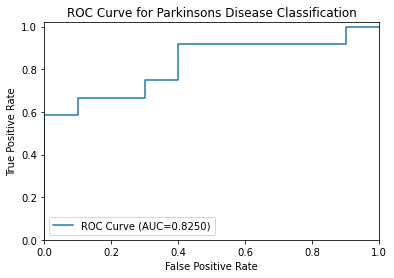

In [16]:
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label=f'ROC Curve (AUC={auc(fpr, tpr):.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Parkinsons Disease Classification')
plt.legend()
plt.show()

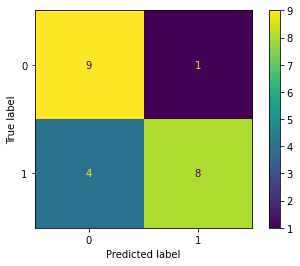

In [17]:
confusion_matrix_ = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_, display_labels = [0, 1])
cm_display.plot()
plt.show()

In [18]:
# Extract TP, TN, FP, FN from confusion matrix
tn, fp, fn, tp = confusion_matrix_.ravel()

print("True Positives (TP):", tp)
print("True Negatives (TN):", tn)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)

True Positives (TP): 8
True Negatives (TN): 9
False Positives (FP): 1
False Negatives (FN): 4


In [19]:
recall = tp /(tp + fn)
print("Recall:", recall)

Recall: 0.6666666666666666


## Results

The classifier works better than chance based on these metrics: 
- Accuracy score of .773
- AUC score of .825 

The confusion matrix displays the number of observations that are in a group and it's predicted group. It looks at the true positives, true negatives, false positives and false negatives. The best case scenario is to have maximize the number of true postives and true negatives, while minimizing the amount of false positives and false negatives. 

In terms of a medical diagnosis, looking at recall is essential. Recall asks the question: of all people with PD, how many were predicted to have PD? The best outcome is to have a recall that is 1, or close to 1, which means that observations of false negatives need to be 0, or close to 0. The best outcome  means that of all people with PD, all of them get predicted correctly resulting in the individual getting help from a clinician. 

The recall for the PD classifier is .667. This means that out of the 12 individuals who actually have PD, 4 of them got classified incorrectly. In terms of recall, the PD classifer is a decent model, but still not a good model. 